# Linear Regression - an example

Working through a linear regression example from scratch.

Jim Mahoney | April 1 2020

### Step 0: get our software tools ready

In [21]:
# dependencies
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import numpy as np
import random

In [42]:
# function definitions and tests

def line(a, b, x):
    """ return y value of linear model : y = a * x + b """
    # This is our machine learning model : 
    #    · (a,b) are the parameters that define the model.
    #    · x is the feature
    #    · y is the target
    return a * x + b

# reality check : with (a,b)=(2,3) and x=4 should be 2 * 4 + 3 = 11
assert line(2, 3, 4) == 11

def squared_length(xs):
    """ return squared length of a vector (i.e. list of values) """
    return sum([xs[i]**2 for i in range(len(xs)) ])    

# reality check : with xs=[3,4] should be 5**2
assert squared_length([3, 4]) == 5**2

def length(xs):
    return np.sqrt( squared_length(xs) )

def normalize(xs):
    """ return a unit length vector in the same direction as xs """
    length_xs = length(xs)
    return [xs[i]/length_xs for i in range(len(xs))]

def error(a, b, xs, ys):
    """ return mean sum of squared errors between ys and linear model (a,b) with features xs """
    # Taking the mean makes sure that this means roughly the same thing
    # independent of the size of the set we're checking, so that for example
    # on a training and test set of different sizes we can compare them.
    return squared_length([line(a, b, xs[i]) - ys[i] for i in range(len(xs))]) / len(xs)

def gradient_error_norm(a, b, xs, ys, da=1e-6, db=1e-6):
    """ Return the normalized (i.e. length=1)
        gradient (i.e. a vector rate of change in each direction = [d_error/da, d_error/db])
        of the squared error length given features xs and target ys. """
    # Notes :
    #   * The values (da,db) are the small offsets from (a,b) used 
    #     to calculate the derivative numerically. 
    #   * Here I'm doing this by derivative by brute force differences,
    #     not by taking an analytic derivative. 
    #   * This definition is only for this particular case,
    #     with two model parameters (a,b) and a give function error().
    delta_error_a = error(a+da/2, b, xs, ys) - error(a-da/2, b, xs, ys)
    delta_error_b = error(a, b+db/2, xs, ys) - error(a, b-db/2, xs, ys)
    return normalize( [delta_error_a / da, delta_error_b / db] )

def noise(sigma=1.0):
    """ return gaussian noise value with mean=0 and given sigma"""
    return random.gauss(0.0, sigma)

def scatterline(xss, yss, xlabel='x', ylabel='y', 
                dot_size=2, dot_color='blue', dot_label=None,
                line=None, line_color='red', line_width=1.0, line_label=None,
                is_first=True):
    """ Draw a scatter plot (or part of a plot), which may have a line on it """
    if is_first:
        plt.figure(dpi=220, figsize=(2.5, 2.5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(xss, yss, s=dot_size, c=dot_color, label=dot_label)
    if line:
        (a,b) = line
        line_label = f'y = {a:0.3} x + {b:0.3}'
        #plt.title(f'y = {a:0.3} x + {b:0.3}')
        xs_line = [min(xss), max(xss)]
        ys_line = [a * x + b for x in xs_line]
        plt.plot(xs_line, ys_line, color=line_color, linewidth=line_width, label=line_label)
    if dot_label or line:
        plt.legend(loc='upper left', fontsize='smaller')
        
def indices_train_test(n, train_fraction=0.7):
    """ Return list of indeces (i_train, i_test) """
    i = list(range(n))                    # indices for all the data
    n_train = int(n * train_fraction)     # size of training set
    i_train = random.sample(i, n_train)   # random sampling without replacement
    i_test = list(set(i) - set(i_train))  # indeces not in training set
    return (i_train, i_test)

### Step 1 : create some data

I'm going to create a set of (xs_raw, ys_raw) 
to use that are linear with random gaussian offsets.

I'll also plot it along with the line that I used to create 
it, which I expect will be close to the regression line
that I want to find using gradient descent.

In [43]:
# y = a * x + b is the line I have in mind

a_raw = 1.2     # arbitrily chosen
b_raw = 3.4

n = 100         # number of points
xlow = 10       # lowest x, rest follow the line with noise() added
sigma = 15      # σ for gaussian noise (chosen by trial & error, looking at the plot)

xs_raw = [ i + noise(sigma)  for i in range(xlow, xlow + n) ]
ys_raw = [ line(a_raw, b_raw, x) + noise(sigma) for x in xs_raw ]

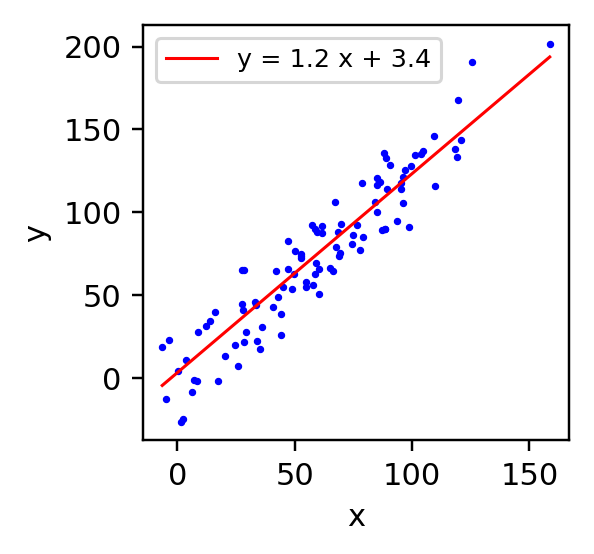

In [44]:
scatterline(xs_raw, ys_raw, line=(a_raw, b_raw))

### Step 2 : partition data into training and test sets

I'll put 70% (my default) into the training set.

And let's see what this separation looks like.

In [45]:
(i_train, i_test) = indices_train_test(n)

xs_train = [xs_raw[i] for i in i_train]
ys_train = [ys_raw[i] for i in i_train]

xs_test = [xs_raw[i] for i in i_test]
ys_test = [ys_raw[i] for i in i_test]

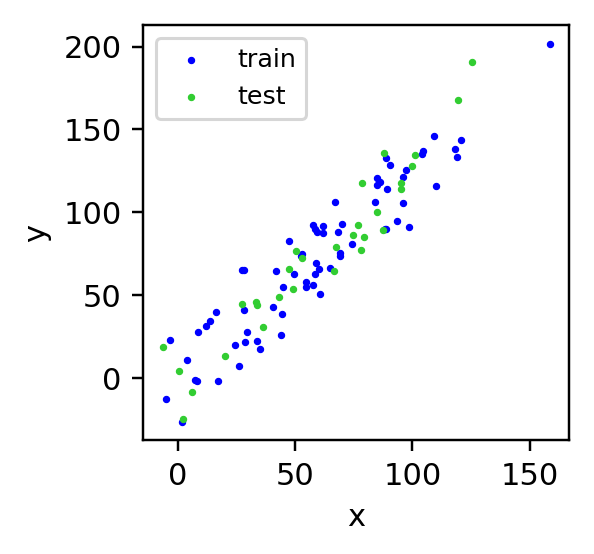

In [61]:
scatterline(xs_train, ys_train, dot_color='blue', dot_label='train')
scatterline(xs_test, ys_test, dot_color='limegreen', dot_label='test', is_first=False)

### Step 3:  do gradient descent to find $(a,b)$ from training data

Now we're ready to apply the gradient descent algorithm
to numerically search for the line defined by $(a, b)$ ,
using the training set x_train and targets y_train
to search for the minimum of the error function.

If the error function is smooth with nice minimum, like a bowl, 
the algorithm will decrease the error until it finds the minimum,
then overshoot the best value and the error will increase.

After a bit of trial and error, I decided to decrease the step size
each time the error increased, trying to converge on a better value
for the lowest error.





In [66]:
# Chose an arbitrary starting values for the linear model parameters .
(a, b) = (10.0, 20.0)    #  (line slope, line intercept)

# Choose size of each step and number of steps to take.
# TODO : stop automatically once the (a,b) converge
#        or error rate of change is very small.
step = 0.1
max_steps = 500
max_upsteps = 3
change_rate = 10000

verbose = False

# Keep track of error, a, b for each step so we can see what is happening
error_tracking = [error(a, b, xs_train, ys_train)]
a_tracking = [a]
b_tracking = [b]

# Main loop : change (a,b) in small steps in negative gradient direction
# ... until it looks like we're done.
i_step = 0
up_steps = 0
while True:
    i_step += 1
    grad = gradient_error_norm(a, b, xs_train, ys_train)    # find gradient 
    (da, db) = (-step * grad[0], -step * grad[1] )
    (a, b) = (a + da, b + db)                               # use it to update (a, b)
    change_rate = (da/a)**2 + (db/b)**2
    err = error(a, b, xs_train, ys_train)
    error_tracking.append(err)                              # remember err, a, b 
    a_tracking.append(a)                                    #  ... for later plotting
    b_tracking.append(b)
    d_err = error_tracking[-1] - error_tracking[-2]
    
    if verbose:
        print(f' i={i_step} grad=({grad[0]:5.2}, {grad[1]:5.2}) ' + \
              f' a={a:6.3}  b={b:6.3}  error={err:8.4}  ' + \
              f' d_err={d_err:8.5} change={change_rate:8.5}')
    
    if d_err > 0:
        up_steps += 1
        step = step/2
        print(f' error increased! Decreasing step size at i_step={i_step} to step={step}')
        
    if up_steps > max_upsteps:
        print(f' error increased more than {max_upsteps} times!  Stopping at i_step={i_step}')
        break

    if i_step > max_steps:
        print(f' i_step exceeded max_steps = {max_steps}! Stopping.')
        break

 error increased! Decreasing step size at i_step=91 to step=0.05
 error increased! Decreasing step size at i_step=93 to step=0.025
 error increased! Decreasing step size at i_step=95 to step=0.0125
 error increased! Decreasing step size at i_step=98 to step=0.00625
 error increased more than 3 times!  Stopping at i_step=98


a, b =  (0.9655057874598731, 19.860118680345675)


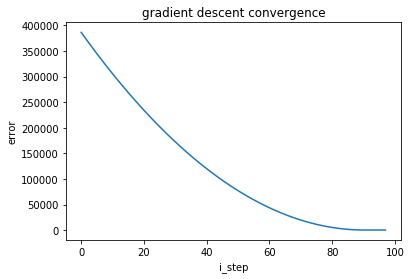

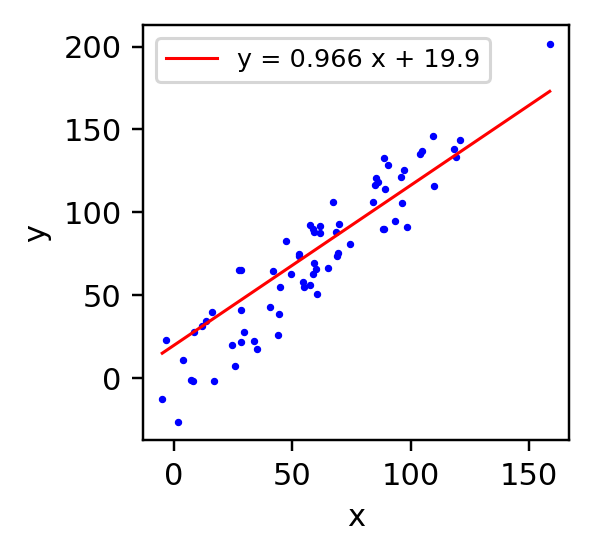

In [67]:
print("a, b = ", (a, b))

# Let's see the convergence rate :
plt.xlabel('i_step')
plt.ylabel('error')
plt.title('gradient descent convergence')
plt.plot(range(i_step), error_tracking[:i_step]);

# And let's see if the line looks OK.
scatterline(xs_train, ys_train, line=(a, b))

    Jim, can I see an animation of that?

Why not?

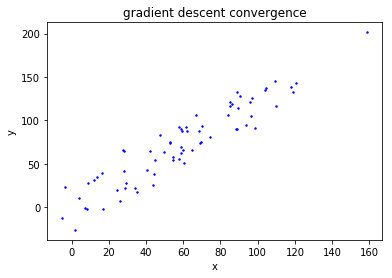

In [68]:
# See http://louistiao.me/posts/notebooks/
#     embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/
#
# Setting up a plot to be animated.

fig, ax = plt.subplots()
plt.scatter(xs_train, ys_train, s=2, c='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.title('gradient descent convergence')
animate_line, = ax.plot([], [], lw=2, c='red')

In [69]:
# Define (x,y) points for each animation step.

def init():
    animate_line.set_data([], [])
    return (animate_line,)

def animate(i):
    y_anim = [ a_tracking[i] * x + b_tracking[i] for x in xs_train]
    animate_line.set_data(xs_train, y_anim)
    return(animate_line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=i_step, interval=20, 
                               blit=True)

In [70]:
HTML(anim.to_jshtml())

### Step 4 : does this look OK for the test set too?

We'll let's look.

 mean training set error =  349.325297823946
 mean test set error =  396.5212684217498


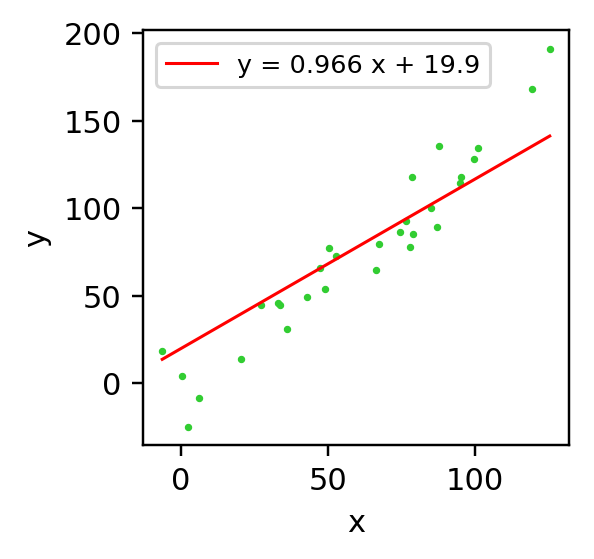

In [62]:
print(" mean training set error = ", error(a, b, xs_train, ys_train))
print(" mean test set error = ", error(a, b, xs_test, ys_test))

scatterline(xs_test, ys_test, line=(a, b), dot_color='limegreen')

Not bad. ;)